# Analysis of Melbourne's Living Environment
**10 May 2022 | 02806 Social Data Analysis & Visualization**


**By Emma Valen Rian (s217079), Eper Stinner (s217159), Aaron Alberg (s217050)**


_Access our explanation and data sources [here](https://github.com/aaronalberg/social-data-notebook)_

**_NOTE: SOME OF THESE VISUALIZATIONS DO NOT RENDER OR CAUSE STRANGE BEHAVIOR OUTSIDE OF GOOGLE CHROME_**

Melbourne is the second largest city in Australia, and its [metropolitan area alone](https://www.britannica.com/place/Melbourne) is home to more than a million people. In this article we want to take a closer look at how it is to live in central Melbourne by exploring the relationship between wealth, environmental conditions and access to services. Do the rich people in Melbourne have access to more services and a cleaner living environment? And does Melbournes residents care about living next to green spaces? Stay tuned to explore these questions in further detail with us.

We will be using three different public datasets to perform our analysis of Melbourne's living environment. The first one is a housing dataset, which contains records of houses sold in greater Melbourne over a span of ~2 years. By looking at house prices in different suburbs of Melbourne we can get an understanding of the wealth of the residents living there. The second dataset describes Melbourne's urban forest, by providing information about every tree's location, age and more. This dataset gives an indication about the amount of green spaces available in the city. The third and last dataset we will take a look at is an overview of different services in the city and their location. This dataset provides information about services like transportation, health, schools and recreation.

Let us first explore the data with some maps. Can we see some patterns between the location (and price) of houses and the proximity of green spaces and public services?

The following map shows an overview of houses sold in the city of Melbourne. We only want to investigate houses within the boundaries of the 14 main suburbs in the municipality of Melbourne, and the boundary is shown as a blue line here.
**Hover over a dot to see how much a house costs!**

In [1]:
# Relevant imports
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import folium
from folium import plugins
from folium.plugins import HeatMap, HeatMapWithTime
from folium import FeatureGroup
import ast
import haversine as hs
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, show
output_notebook()

import seaborn as sns
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error # for calculating the cost function
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.tree import export_graphviz
from sklearn import tree

# Load Melbourne trees dataset into pandas DataFrame
url = "https://data.melbourne.vic.gov.au/api/views/fp38-wiyy/rows.csv?accessType=DOWNLOAD"
trees_data = pd.read_csv(url)
trees_data["Date Planted"] = pd.to_datetime(trees_data["Date Planted"], format="%d/%m/%Y")
# print(trees_data.shape)
# trees_data.head()

# Load Melbourne house dataset into pandas DataFrame
cols = ["Suburb", "Address", "Rooms", "Type", "Price", "Method", "SellerG",
       "Date", "Distance", "Postcode", "Bedroom2", "Bathroom", "Car",
       "Landsize", "BuildingArea", "YearBuilt", "CouncilArea", "Latitude",
       "Longitude", "Regionname", "Propertycount", "Services_500m" , "Trees_500m"]
housing_data = pd.read_csv("housing_services_trees.csv", header=0, names=cols)
housing_data['Date'] = pd.to_datetime(housing_data['Date'])
houses_with_trees = housing_data

# Load Melbourne municipal boundary from shapefile (City of Melbourne Open Data)
municipal_boundary_url = "https://data.melbourne.vic.gov.au/api/geospatial/ck33-yh8z?method=export&format=Shapefile"
geoJSON_df = gpd.read_file(municipal_boundary_url)
[municipal_boundary] = gpd.GeoSeries(geoJSON_df.geometry)

# Filter houses to only those within the municipal boundary
in_municipality = housing_data[["Latitude", "Longitude"]].apply(lambda x: municipal_boundary.contains(Point((x.Longitude, x.Latitude))), axis=1)
filtered_houses = housing_data[in_municipality]

# Filter house dataset to include only those that have a price
pd.notna(filtered_houses.Price).value_counts()
has_price = pd.notna(filtered_houses.Price)
has_price = filtered_houses[has_price]
houses_with_price = has_price.reset_index(drop=True)

# houses_with_price

houses_concentration = [([x.Latitude, x.Longitude], x.Price) for x in houses_with_price.itertuples()]
mapM = folium.Map([-37.81, 144.94], zoom_start=13)
folium.GeoJson(municipal_boundary).add_to(mapM)
for (loc, price) in houses_concentration:
    circle = folium.Circle(location=loc, radius=18, color="#ff1427", fill_color="#ff1427", fill_opacity=1, tooltip=f"Price: {price:.0f} AUD").add_to(mapM)
mapM

Loading BokehJS ...

Let's see how prices compare across these neighborhoods! The industrial areas near the ports don't seem to have many house sales in the last few years, which makes sense but makes those regions less interesting to explore. Next let's get an understanding of the relative numbers we're working with.

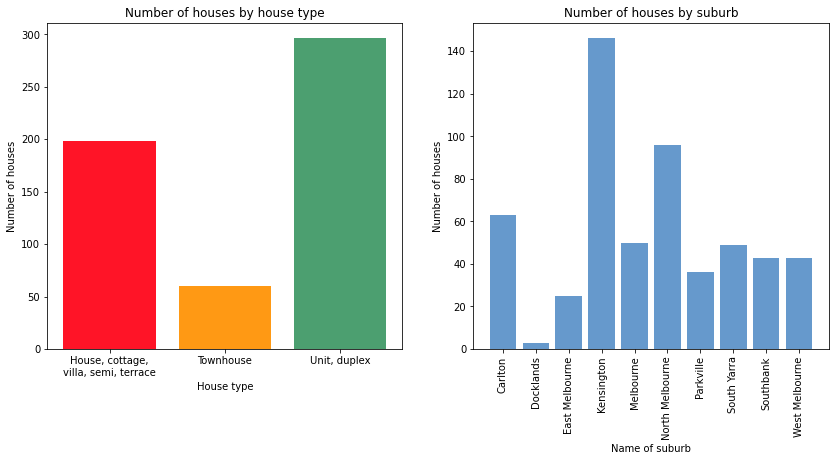

In [2]:
# Define type labels and colors
type_labels = ["House, cottage,\nvilla, semi, terrace", "Townhouse", "Unit, duplex"]
colors = ["#FF1427", "#FF9914", "#4C9F70"]

# Group records by house type
house_types = houses_with_trees.Type.value_counts().sort_index()
# Group records by suburb
suburb_houses = houses_with_trees.Suburb.value_counts().sort_index()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# Plot houses by house type
axs[0].bar(house_types.index, height=house_types.values, color=colors)
axs[0].set_title(label="Number of houses by house type")
axs[0].set_xlabel(xlabel="House type")
axs[0].set_ylabel(ylabel="Number of houses")
axs[0].set_xticks(house_types.index)
axs[0].set_xticklabels(type_labels)
# Plot houses by location (suburb)
plt.xticks(rotation=90)
axs[1].bar(suburb_houses.index, height=suburb_houses.values, color="#6699CC")
axs[1].set_title(label="Number of houses by suburb")
axs[1].set_xlabel(xlabel="Name of suburb")
axs[1].set_ylabel(ylabel="Number of houses")
plt.show()

We clearly have more datapoints for certain neighborhoods and house types, but we don't know for sure if its data bias or not. A quick Google [search](https://en.wikipedia.org/wiki/Docklands,_Victoria) tells us that Docklands is an industrial area that was abandoned until 20 years ago and now has apartments for rent. A low number of house sales given this background makes sense! We're working with a relatively narrow time range, but let's see if temporal patterns reveal anything interesting. Take a look at this graph of prices over time.

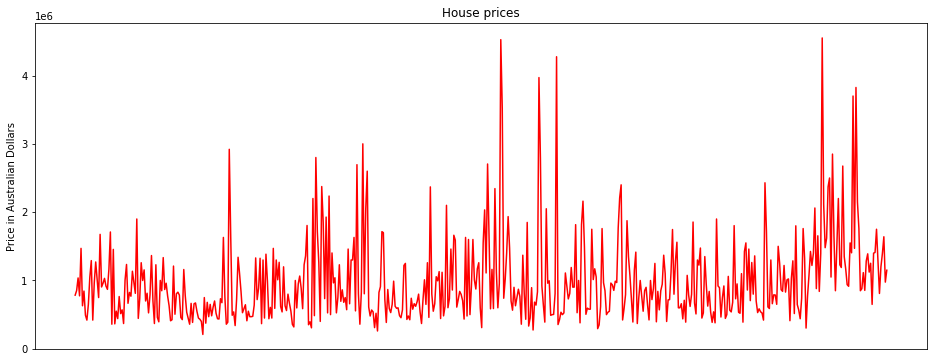

In [3]:
house_prices = houses_with_trees.Price.value_counts()

fig, ax = plt.subplots(figsize=(16, 6))
plt.xticks(rotation=90)
ax.plot(houses_with_trees.index, houses_with_trees.Price, color='red')
ax.set_title(label="House prices")
ax.set_ylabel(ylabel="Price in Australian Dollars")
ax.set_xticks([])
plt.show()

There seems to be a slight increase over time (with a few crazy mansion sales), but inflation is an easy explanation for this (i.e. real house prices in this time frame haven't changed much). What about looking at sales on the map? _make sure to press play to see trends over time!_ This visualization shows individual house sales by month.

In [4]:
months = [g for n, g in houses_with_trees.groupby(pd.Grouper(key='Date',freq='M'))]
MBmap = folium.Map([-37.84, 144.94], zoom_start=12)
frames = []
for month in months:
    if len(month.index) < 1:
        continue
    points = []
    for x, y in zip(month['Latitude'], month['Longitude']):
        points.append([x,y])
    
    frames.append(points)
HeatMapWithTime(frames, radius=20).add_to(MBmap)
MBmap

Next let's compare prices across the neighborhoods:

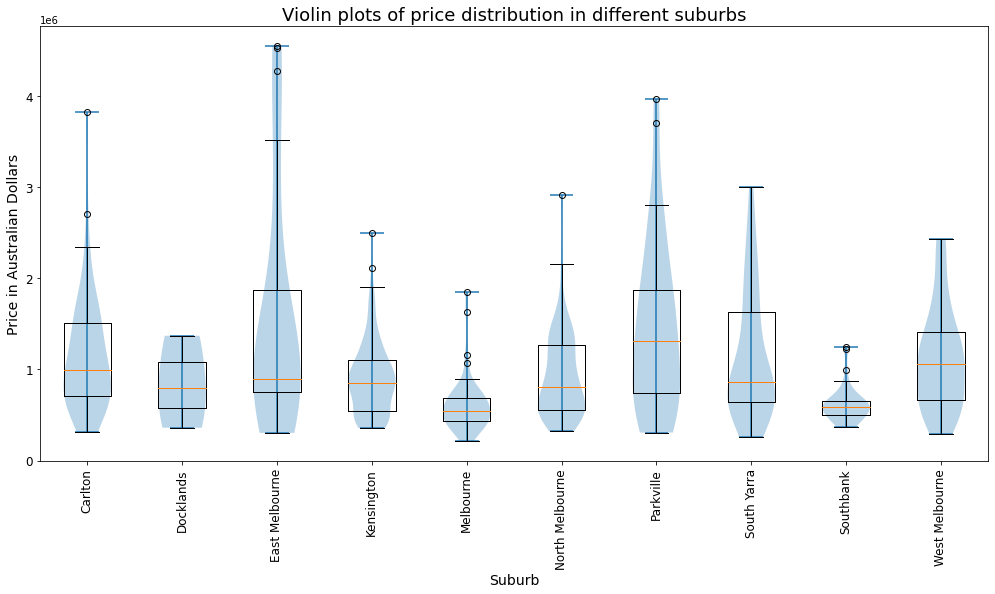

In [7]:
suburbs = sorted(houses_with_trees.Suburb.unique())
box_data = np.array([np.asarray(houses_with_trees[houses_with_trees.Suburb == s].Price) for s in suburbs], dtype=object)
#Displaying violin plots
fig, ax = plt.subplots(figsize =(17, 8))
ax.violinplot(box_data,showmedians=False)
ax.boxplot(box_data)
ax.set_xticklabels(suburbs)
ax.set_title('Violin plots of price distribution in different suburbs',fontsize=18)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel("Price in Australian Dollars", fontsize=14)
ax.set_xlabel("Suburb",fontsize=14)

plt.show()

OK, this helps us identify wealthier neighborhoods. Areas near the Central Business District (generally, neighborhoods with Melbourne in the name) seem to trend higher. What about different types of homes?

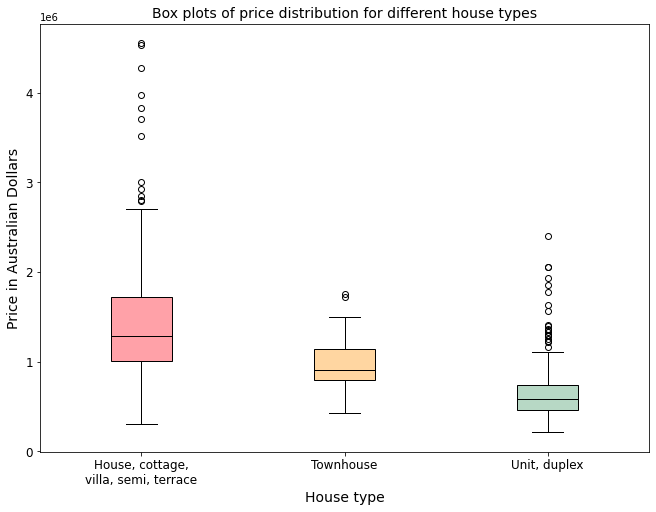

In [8]:
houses_with_trees = housing_data
suburbs = sorted(houses_with_trees.Suburb.unique())
types = sorted(houses_with_trees.Type.unique())
type_labels = {'u': 'Unit, duplex', 'h': 'House, cottage,\nvilla, semi, terrace', 't': 'Townhouse'}
box_data = np.array([np.asarray(houses_with_trees[houses_with_trees.Type == t].Price) for t in types], dtype=object)
xtick_labels = [type_labels[t] for t in types]
colors = ["#FF1427", "#FF9914", "#4C9F70"]

fig, ax = plt.subplots(1, 1, figsize=(9, 7), constrained_layout=True)
#Displaying box plots
boxplots = ax.boxplot(box_data, patch_artist=True)
ax.set_xticklabels(xtick_labels)
ax.set_title('Box plots of price distribution for different house types',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel("Price in Australian Dollars", fontsize=14)
ax.set_xlabel("House type",fontsize=14)
#Color code boxes according to types
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(boxplots[element], color="black")
for (patch, color) in zip(boxplots["boxes"], [f"{c}66" for c in colors]):
  patch.set_facecolor(color)

# #Displaying violin plots
# violinplots = ax[1].violinplot(box_data, showmedians=True)
# ax[1].set_xticklabels(xtick_labels)
# ax[1].set_title('Violin plots of price distribution for different house types',fontsize=14)
# ax[1].set_ylabel("Price in Australian Dollars", fontsize=14)
# ax[1].set_xlabel("House type",fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

#Color violin plots according to types
# for element in ['bodies', 'cbars', 'cmaxes', 'cmedians', 'cmins']:
#         plt.setp(violinplots[element], color="black")
# for (pc, color) in zip(violinplots['bodies'], [f"{c}66" for c in colors]):
#     pc.set_facecolor(color)

plt.show()

Pretty wide spreads for all of them, but single family homes trending higher. Makes sense so far!

We don't want to be naive and assume all of our data is perfect. Let's take a look at the 'Distance' property provided by our dataset. Experiment with the toggles and see if you can find anything weird. 

In [9]:
# Check distance for errors
dist_groups = sorted(houses_with_trees.Distance.value_counts().index)
# Define colors for different distance groups
colors = ["black", "darkred", "#E600E5", "#E6C458", "#E6006F", "#0A78E6", "lightblue", "#17FFE6", "red", "orange", "#E6C5FF", "#8BE609", "cadetblue", "#609F60", "#9E7A59", "lightgreen"]
mapM = folium.Map([-37.81, 144.94], zoom_start=13, tiles="cartodbpositron")
# Add distance groups to separate layers on map
for idx, d in enumerate(dist_groups):
    feature_group = FeatureGroup(name=f"{dist_groups[idx]}km")
    house_group = houses_with_trees[houses_with_trees["Distance"] == d]
    house_locs= [([x.Latitude, x.Longitude], x.Price) for x in house_group.itertuples()]
    for (loc, p) in house_locs:
      popup = folium.Popup(f"Price: {p}")
      circle = folium.Circle(location=loc, radius=30, color="colors[idx]", fill_color=colors[idx], fill_opacity=1).add_child(popup)
      feature_group.add_child(circle)
    mapM.add_child(feature_group)
mapM.add_child(folium.map.LayerControl(collapsed=False))
mapM

You probably noticed that entire neighborhoods have the exact same distance value! Neighborhoods can be pretty widespread, so assigning a uniform value with potential error of ~50% isn't super helpful. Even worse, you may have noticed that houses in central Melbourne fall under both the 0km and 2.8km marker. Clearly this feature is unreliable! We won't be using the distance property.

Let's see where homes are in relation to the green spaces. Hover over the map to see the different neighborhoods.

In [10]:
# Download and preprocess spatial data (districts/suburbs of Melbourne)
districts_url = "https://data.melbourne.vic.gov.au/api/geospatial/m7yp-p495?method=export&format=Shapefile"
district_names = ["Flemington", "Port Melbourne", "North Melbourne", "West Melbourne", "South Yarra",
                  "Royal Melbourne Hospital", "Carlton", "World Trade Centre", "Southbank", "3054", 
                  "Parkville", "3004", "East Melbourne", "Docklands", "Melbourne", "University Of Melbourne", "Kensington"]

geoJSON_df = gpd.read_file(districts_url)
geoJSON_df["district"] = district_names
district_boundaries = geoJSON_df.drop(["mccid_gis", "maplabel", "name", "xorg", "mccid_str", "xsource", "xdate", "mccid_int"], axis=1)
district_shapes = gpd.GeoSeries(district_boundaries.geometry)

# Compute number of trees in each district
district_data = []
for idx, s in enumerate(district_shapes):
    in_district = trees_data[["Latitude", "Longitude"]].apply(lambda x: s.contains(Point((x.Longitude, x.Latitude))), axis=1)
    district_trees = len(trees_data[in_district])
    district_name = district_names[idx]
    district_data.append([district_name, district_trees])
district_trees_df = pd.DataFrame(district_data, columns=["district", "trees"])
# Format suburb shape, name and tree count for plotting
district_trees_geo = district_boundaries.merge(district_trees_df, on="district")
district_trees_geo.head()

mapM = folium.Map([-37.81, 144.94], zoom_start=13)
feature_group = FeatureGroup(name=f"Houses in Melbourne")
# Display interactive Choropleth map of district tree counts
folium.Choropleth(
    geo_data=district_trees_geo,
    data=district_trees_geo,
    columns=["district", "trees"],
    key_on="feature.properties.district",
    fill_color="YlGn",
    fill_opacity=.8,
    line_opacity=1,
    legend_name="Number of trees",
    smooth_factor=0,
    Highlight= True,
    line_color = "#0000",
    name = "Number of trees in district",
    overlay=True,
).add_to(mapM)

# Mark house sales locations on map
house_locs= [[x.Latitude, x.Longitude] for x in houses_with_trees.itertuples()]
for loc in house_locs:
    feature_group.add_child(folium.Circle(location=loc, radius=3, color="black", fill_color="black", fill_opacity=1))
mapM.add_child(feature_group)

# Add hover functionality.
style_function = lambda x: {"fillColor": "#ffffff", 
                            "color":"#000000", 
                            "fillOpacity": 0.1, 
                            "weight": 0.1}
highlight_function = lambda x: {"fillColor": "#000000", 
                                "color":"#000000", 
                                "fillOpacity": 0.50, 
                                "weight": 0.1}
hover = folium.features.GeoJson(
    data = district_trees_geo,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=["district", "trees"],
        aliases=["district", "trees"],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
mapM.add_child(hover)
mapM.keep_in_front(hover)

# Add dark and light mode. 
folium.TileLayer("cartodbdark_matter",name="dark mode",control=True).add_to(mapM)
folium.TileLayer("cartodbpositron",name="light mode",control=True).add_to(mapM)

# Add a layer controller. 
folium.LayerControl(collapsed=False).add_to(mapM)
mapM

The (very aptly named) Parkville clearly has a high density of trees and is lined with homes as well. Otherwise, high levels of trees doesn't seem to indicate high number of home sales (nor is the inverse shown). This can indicate that trees aren't a significant factor when it comes to home sales.

This map also displays why we shouldn't limit ourselves to classifying houses only by district. Take the example of South Yarra, which has a low number of trees, resulting in a lower green rating for all our sales samples. This might be true for houses in the center of the area, but not for samples near the boundary and next to the Royal Botanic Gardens or Albert Park. This means that we need to consider each house individually when we talk about its price, specific location or number of neighbouring trees.

Let's add the price dimension back in.

In [11]:
# Compute median house prices for each suburb 
median_prices = houses_with_trees.groupby("Suburb").Price.median()
# Compute number of trees, number of house sales samples and corresponding median price for each district
district_data = []
for idx, s in enumerate(district_shapes):
    in_district = houses_with_trees[["Latitude", "Longitude"]].apply(lambda x: s.contains(Point((x.Longitude, x.Latitude))), axis=1)
    district_houses = len(houses_with_trees[in_district])
    district_name = district_names[idx]
    if district_name in median_prices.index:
        district_data.append([district_name, district_houses, median_prices[district_name]])
        
district_houses_df = pd.DataFrame(district_data, columns=["district", "houses", "avg_price"])
df = district_houses_df.merge(district_trees_df, on="district")

source = ColumnDataSource(df)
# add data to be shown in hover tooltip
HOVER = [
    ("District", "@district"),
    ("Houses", "@houses"),
    ("Trees", "@trees"),
    ("Average price", "@avg_price AUD "),
]
p = figure(title="Number of trees, average price and number of samples from each district", x_axis_label="Number of trees",
           y_axis_label="Average price", tooltips=HOVER)
p.circle("trees", "avg_price", size="houses", source=source, muted=True, line_color="red", fill_color="red")
show(p)

Parkville definitely confirms the positive correlation between trees and price, but the other neighborhoods are still not showing a connection between price and tree density. Maybe access to important services or places of interest like churches, public transit, schools, and healthcare is more important?

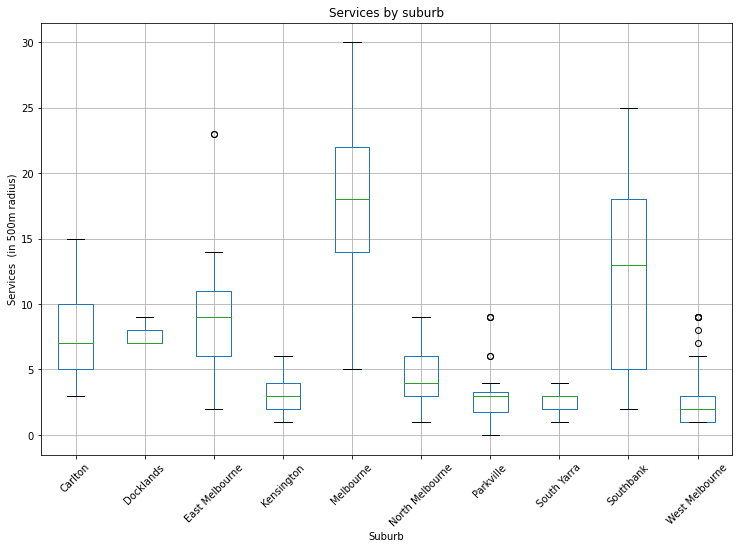

In [12]:
houses_with_trees.boxplot("Services_500m", by="Suburb", rot = 45, figsize=(12,8))
plt.suptitle("")
plt.title("Services by suburb")
plt.ylabel("Services  (in 500m radius)")
plt.ticklabel_format(axis="y", style="plain")

This plot has similar trends as the plot comparing prices and neighborhoods. Promising! Let's look at where the landmarks are in relation to the houses. _Houses are in blue, landmarks in red_

In [13]:
url = 'https://data.melbourne.vic.gov.au/resource/j5vt-ppat.csv'
ldf = pd.read_csv(url)
# display(ldf)
ldf['lat'] = ldf.apply(lambda x: ast.literal_eval(x['geom'])[0], axis=1)
ldf['lng'] = ldf.apply(lambda x: ast.literal_eval(x['geom'])[1], axis=1)


map1 = folium.Map([-37.84, 144.94], zoom_start=12)

for idx, row in ldf.iterrows():
    loc = ast.literal_eval(row['geom'])
    folium.Circle(loc, color='red').add_to(map1)
    
for idx, row in houses_with_trees.iterrows():
    folium.Circle((row['Latitude'], row['Longitude'])).add_to(map1)
map1

A little overwhelming to look at, but landmarks/places of interest are definitely located near the houses. What kinds of services does this dataset include?

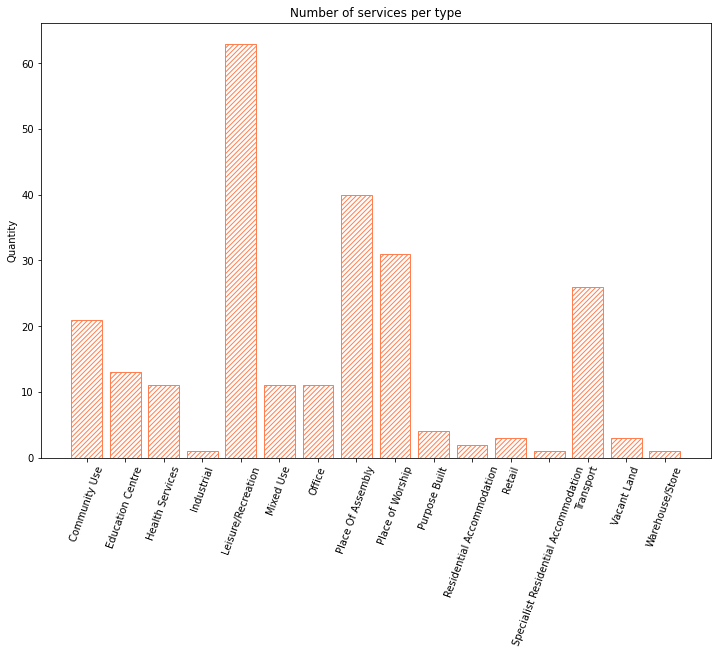

In [14]:
themes = ldf.groupby("theme").size()
plt.figure(figsize=(12,8))
plt.bar(range(len(themes)), themes, fill=False, hatch='/////', edgecolor='coral')
plt.xticks(range(len(themes)), themes.index, rotation=70)
plt.title('Number of services per type')
plt.ylabel('Quantity')
plt.show()

Lots of recreation, places of worship, and transportation. Again makes sense given our spatial distribution. Not quite sure what purpose built means, so we'll throw that out.

Now what if we want to predict future house prices based on our historical data? Let's take a few more looks at some features to see how we can measure them. Firstly is our trees and services. How do we measure these spatial datapoints against each other? In this case, we've decided for you: a house is 'near' a tree or landmark if it's within 500m (a reasonable distance for someone to walk). Here's an example of all the trees within half a kilometer of a house in Kensington.

In [15]:
# Radius in km
max_distance = 0.5

# Pick a house as a reference point
house_lat = houses_with_price.loc[19].Latitude
house_lon = houses_with_price.loc[19].Longitude

# Calculate if each tree is within 500 meters
trees_near = trees_data[["Latitude", "Longitude"]].apply(lambda x: hs.haversine((x.Latitude, x.Longitude), (house_lat, house_lon)), axis=1) <= max_distance
mapM = folium.Map([house_lat, house_lon], zoom_start=15,zoom_control=False,
               scrollWheelZoom=False,
               dragging=True)
folium.Marker(location=[house_lat, house_lon]).add_to(mapM)
for t in trees_data[trees_near.values].itertuples():
     folium.Circle(location=(t.Latitude, t.Longitude), radius=1, color="green", fill_color="green", fill_opacity=1).add_to(mapM)
mapM

Rooms in houses probably vary a lot by home type, price, and other factors. Let's check out by neighborhood to see the differences before we use it in our machine learning.

In [16]:
rooms_in_suburbs = houses_with_trees.groupby(["Rooms", "Suburb"]).size()
room_counts = sorted(houses_with_trees.Rooms.unique())
room_numbers = [str(num) for num in room_counts]
colors = ['#2b83ba', '#abdda4', '#ffffbf', '#fdae61', '#d7191c', '#000000']

from bokeh.io import show
from bokeh.plotting import figure

data =  {'Suburbs' : suburbs}

for room_num in room_counts:
    room_group_counts = []
    for s in suburbs:
        room_group = rooms_in_suburbs[room_num]
        if s in room_group.index:
            room_group_counts.append(room_group[s])
        else:
            room_group_counts.append(0)
    data[str(room_num)] = room_group_counts
    
p = figure(x_range=suburbs, height=250, title="Number of rooms per house by suburb",
           toolbar_location=None, tools="")

p.vbar_stack(room_numbers, x='Suburbs', width=.8, color=colors, source=data, legend_label=room_numbers)

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = 'top_right'
p.legend.orientation = 'horizontal'
p.legend.click_policy='hide'
p.xaxis.major_label_orientation = 'vertical'
show(p)

Before we get into any machine learning, let's take a look at the data we have and check for missing values and data types.

In [17]:
data = pd.read_csv('housing_services_trees.csv')
# There are not a lot of features provided in this dataset, so we will primarily use it to aid our machine learning effort.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         554 non-null    object 
 1   Address        554 non-null    object 
 2   Rooms          554 non-null    int64  
 3   Type           554 non-null    object 
 4   Price          554 non-null    float64
 5   Method         554 non-null    object 
 6   SellerG        554 non-null    object 
 7   Date           554 non-null    object 
 8   Distance       554 non-null    float64
 9   Postcode       554 non-null    float64
 10  Bedroom2       545 non-null    float64
 11  Bathroom       545 non-null    float64
 12  Car            520 non-null    float64
 13  Landsize       494 non-null    float64
 14  BuildingArea   293 non-null    float64
 15  YearBuilt      333 non-null    float64
 16  CouncilArea    554 non-null    object 
 17  Latitude       554 non-null    float64
 18  Longitude 

Not all of this is useful, so we're going to throw some rows away. Fields like 'Address' don't provide much because they are all unique. We already looked for temporal patterns so we won't use 'Date'. 'BuildingArea' is missing for many datapoints, so we'll toss that as well. We'll then drop rows with missing values for important columns like 'Car', 'Landsize', and 'Bedroom2'. Finally, we'll [one hot encode](https://en.wikipedia.org/wiki/One-hot#:~:text=Machine%20learning%20and%20statistics%5Bedit%5D) the categorical data into binary fields. Take a look below at the stats on the updated data set and the correlations between all of our variables.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 476 entries, 0 to 553
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         476 non-null    object 
 1   Rooms          476 non-null    int64  
 2   Type           476 non-null    object 
 3   Price          476 non-null    float64
 4   Postcode       476 non-null    float64
 5   Bedroom2       476 non-null    float64
 6   Bathroom       476 non-null    float64
 7   Car            476 non-null    float64
 8   Landsize       476 non-null    float64
 9   Latitude       476 non-null    float64
 10  Longitude      476 non-null    float64
 11  Propertycount  476 non-null    float64
 12  Services_500m  476 non-null    float64
 13  Trees_500m     476 non-null    int64  
dtypes: float64(10), int64(2), object(2)
memory usage: 55.8+ KB



The Root Mean Squared Error is:  400885.367


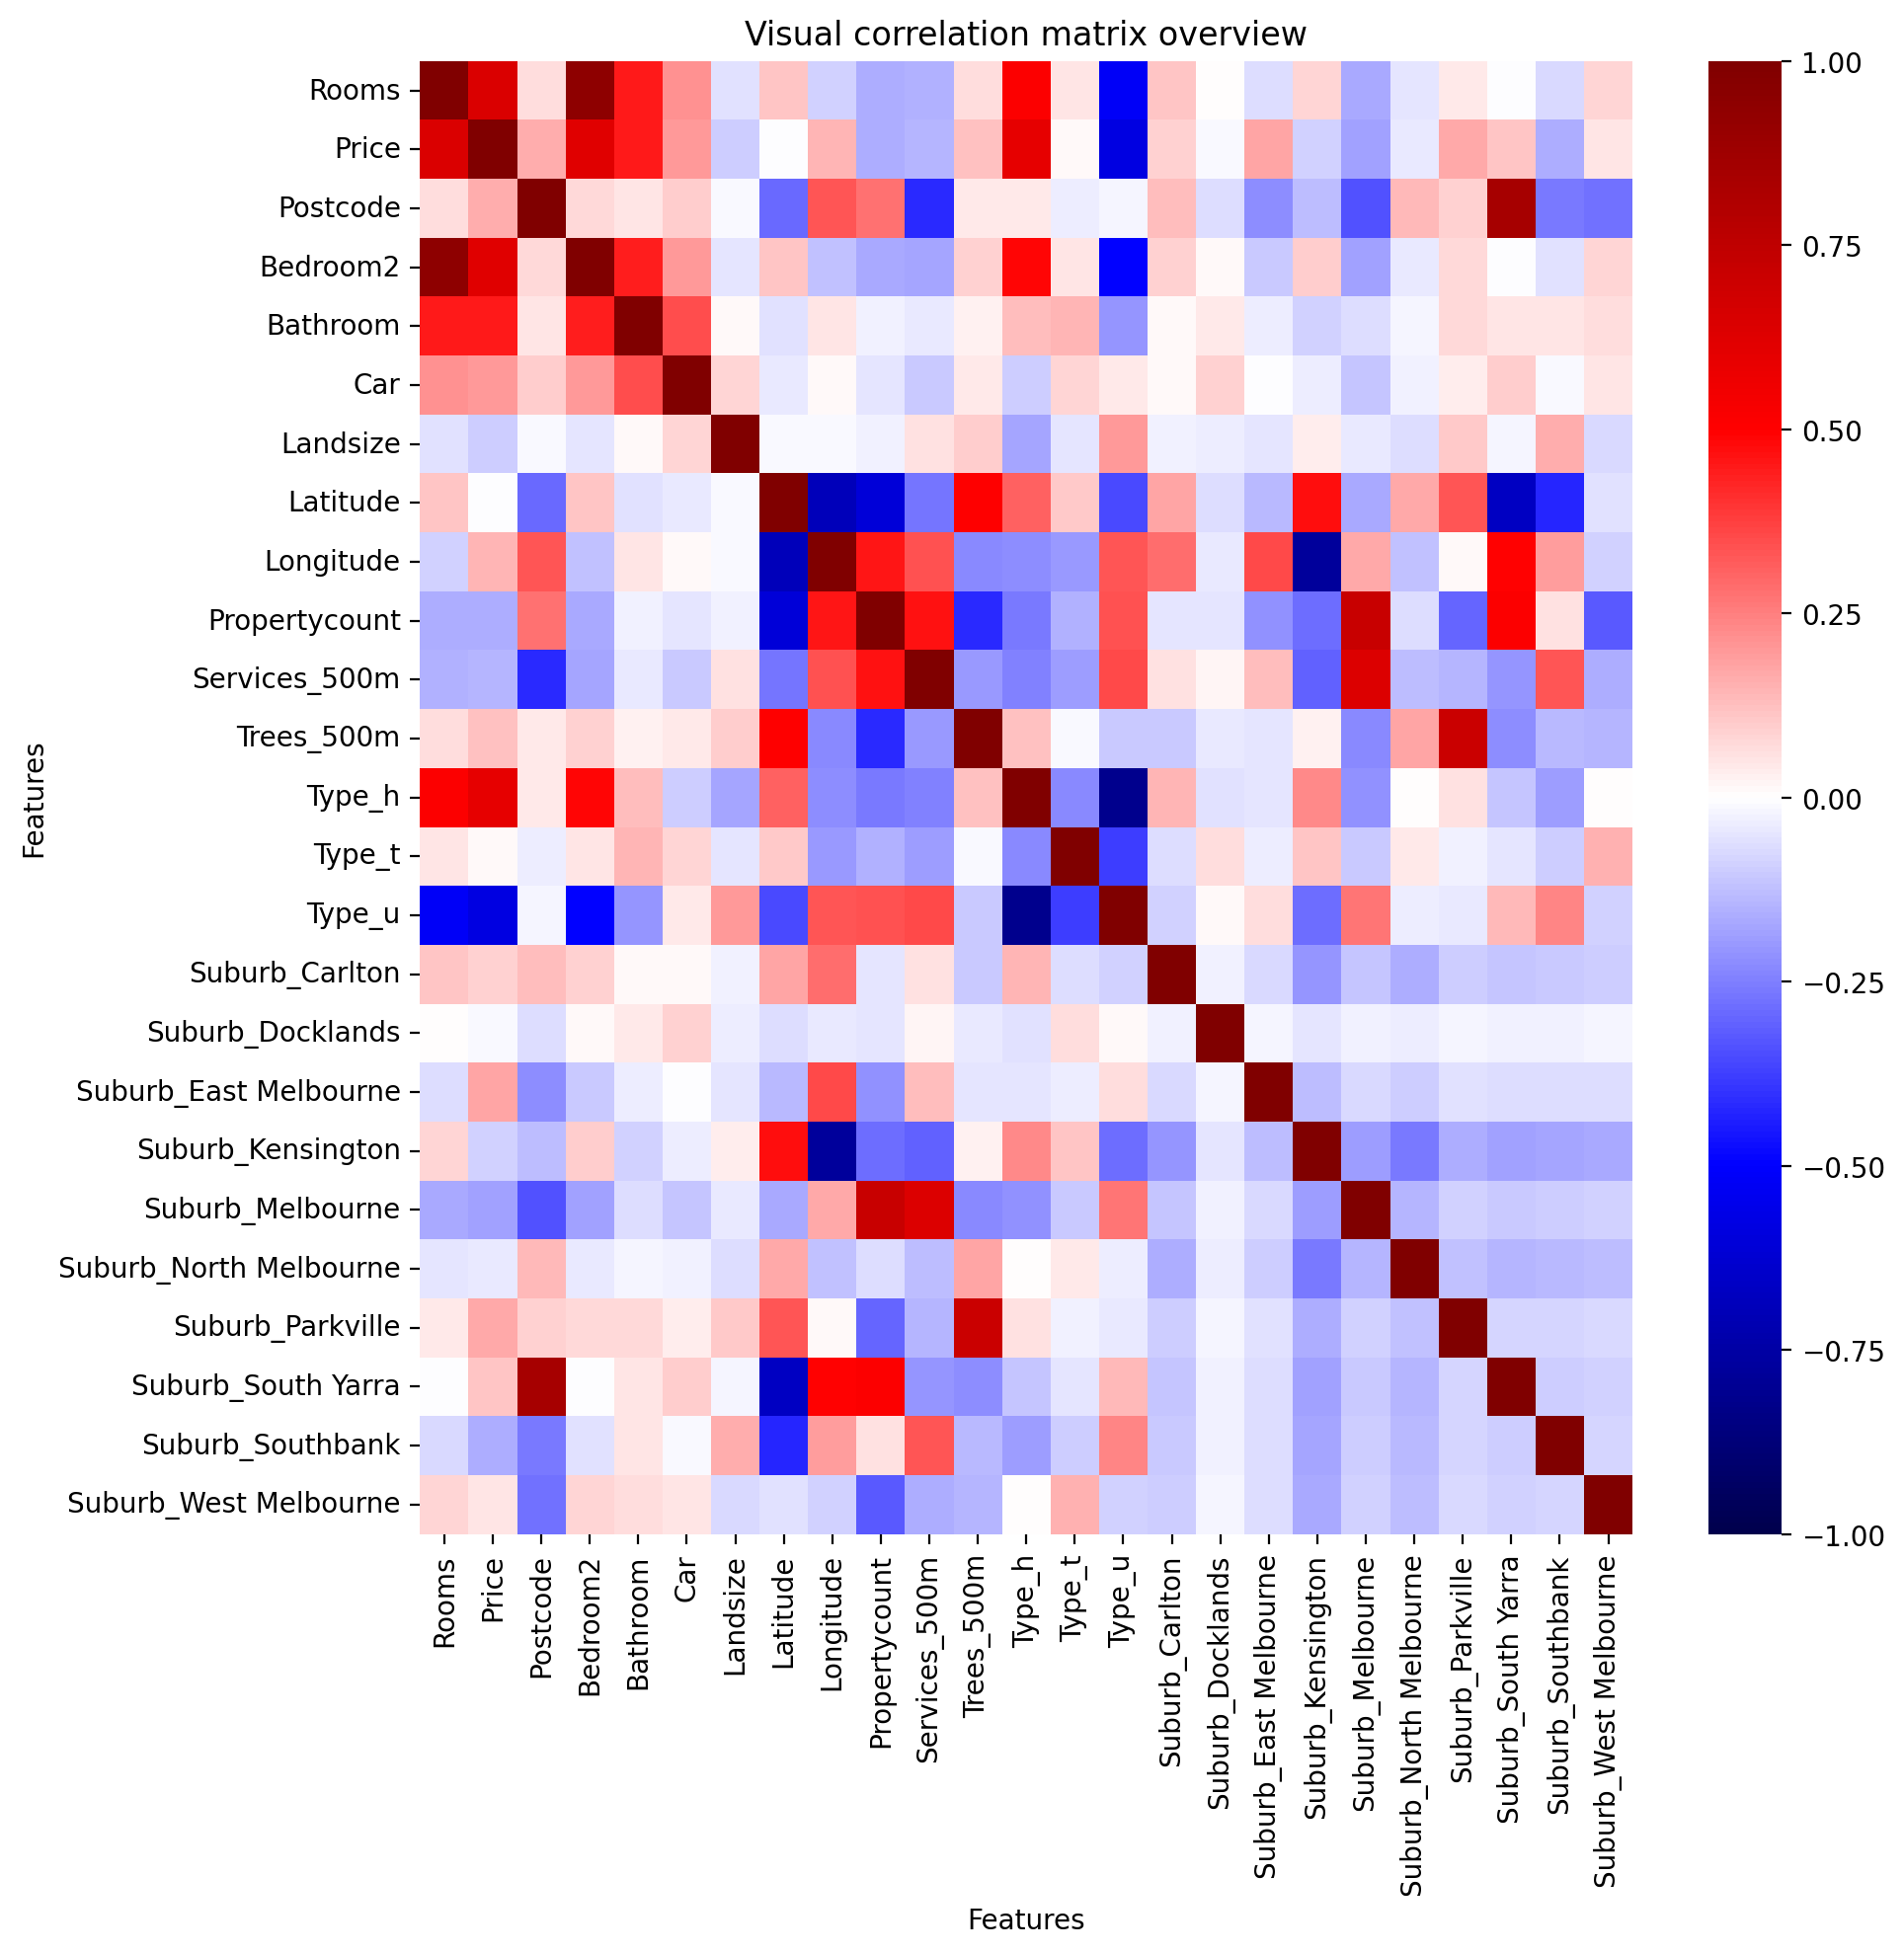

In [18]:
data = pd.read_csv('housing_services_trees.csv')

#- One hot encoding for:
#     - Type (need to know if it is a house, apartment/unit or townhouse)
#     - Suburb, relevant to see if there are patterns in the different suburbs
# - Remove:
#     - Other categorical/object attributes that are not encoded and attributes that have many NaN values (BuildingArea, YearBuilt)
# Drop attributes of object type that is not encoded and attributes that have many NaN values (BuildingArea, YearBuilt)
data = data.drop(["Address","Distance", "CouncilArea", "Date", "Regionname", "SellerG", "Method", "BuildingArea", "YearBuilt"], axis=1)

# Remove rows with NaN from important columns with few NaN values - will still have enough rows to evaluate
data = data.dropna(axis=0, subset=["Car", "Landsize", "Bedroom2", "Bathroom"])

data.info()
# leaves us with 476 rows
# print("Suburbs: ", data["Suburb"].unique())
# One hot encoding function

def one_hot_encoding(df, col:str):
    # make list to get correct names of columns, sorting because the encoding is done alphabetically
    column_labels = sorted(list(df[col].unique()))
    # creating one hot encoder object 
    onehotencoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
    # reshape the 1-D array to 2-D as fit_transform expects 2-D and finally fit the object 
    temp = onehotencoder.fit_transform(df[col].values.reshape(-1,1))
    # add this back into the original dataframe 
    df_one_hot = pd.DataFrame(temp, columns = [col+"_"+str(label) for label in column_labels])
    # join the encoded and original dataframe together
    encoded_df = df.join(df_one_hot)
    #dropping the old label column 
    encoded_df= encoded_df.drop([col], axis=1)
    return encoded_df
data = data.reset_index() # remember to reset index to avoid NaNs when encoding!
temp_df = one_hot_encoding(data, "Type")
#temp_df = temp_df.reset_index()
encoded_df = one_hot_encoding(temp_df, "Suburb")
#encoded_df.info()
encoded_df = encoded_df.drop(["index"], axis=1)
# Lets explore the correlations in our data set 
plt.figure(figsize=(10, 10), dpi=200)
# plt.clim(-1, 1)
plt.title("Visual correlation matrix overview")
sns.heatmap(encoded_df.corr(), annot=False, cmap='seismic', vmin=-1, vmax=1)
plt.ylabel("Features")
plt.xlabel("Features")
plt.tight_layout()
# plt.show()
# Split into prediction attributes and goal attribute

def prepare_input_split(df):
    # Specify input for train_test_split
    prediction_df = df.copy()
    y = prediction_df.pop("Price") # extract target and pop from df
    X = prediction_df              # complete df except from target
    return X, y

#print(encoded_df)

X, y = prepare_input_split(encoded_df)

# Set split to 70/30
test_proportion = 0.3

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_proportion, random_state=44)

# Create regression tree and train on training data

model = RandomForestRegressor(n_estimators = 10, random_state = 42, max_depth=4).fit(X_train, y_train)
# Predict data
predictions = model.predict(X_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, predictions)), '.3f'))
print("\n\n\nThe Root Mean Squared Error is: ", rmse)
#print(predictions)

# Have to round predicted values to integers to be able to calculate classification metrics
# predictions_int = [round(x) for x in predictions]
#result_rf_df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_rf})

#display(result_rf_df)
# print("\nPerformance statistics random forest:")
# print('Accuracy: %.3f%%' % (accuracy_score(y_test, predictions_int)*100.0))
# print('Precision: %.3f%%' % (precision_score(y_test, predictions_int, average='weighted')*100.0))
# print('Recall: %.3f%%' % (recall_score(y_test, predictions_int, average='weighted')*100.0))

Alright let's take a look here. The RMSE of our model is ~$400000 AUD which really isn't a great look. That means that either a) our historical data is not complete enough or b) the variables we have access to do not have a particularly strong correlation to price. Let's take a look at that correlation matrix to see what's up. Some of them are very intuitive, like price being correlated to neighborhood or type of house. Others are intuitive but not in quite a useful way, like having a second bedroom correlating to having more rooms or the fact that being an apartment is negatively correlated to being a house(duh!). There are some interesting patterns to see here though: Services does correlate to postcode, and garage access correlates to rooms and price.

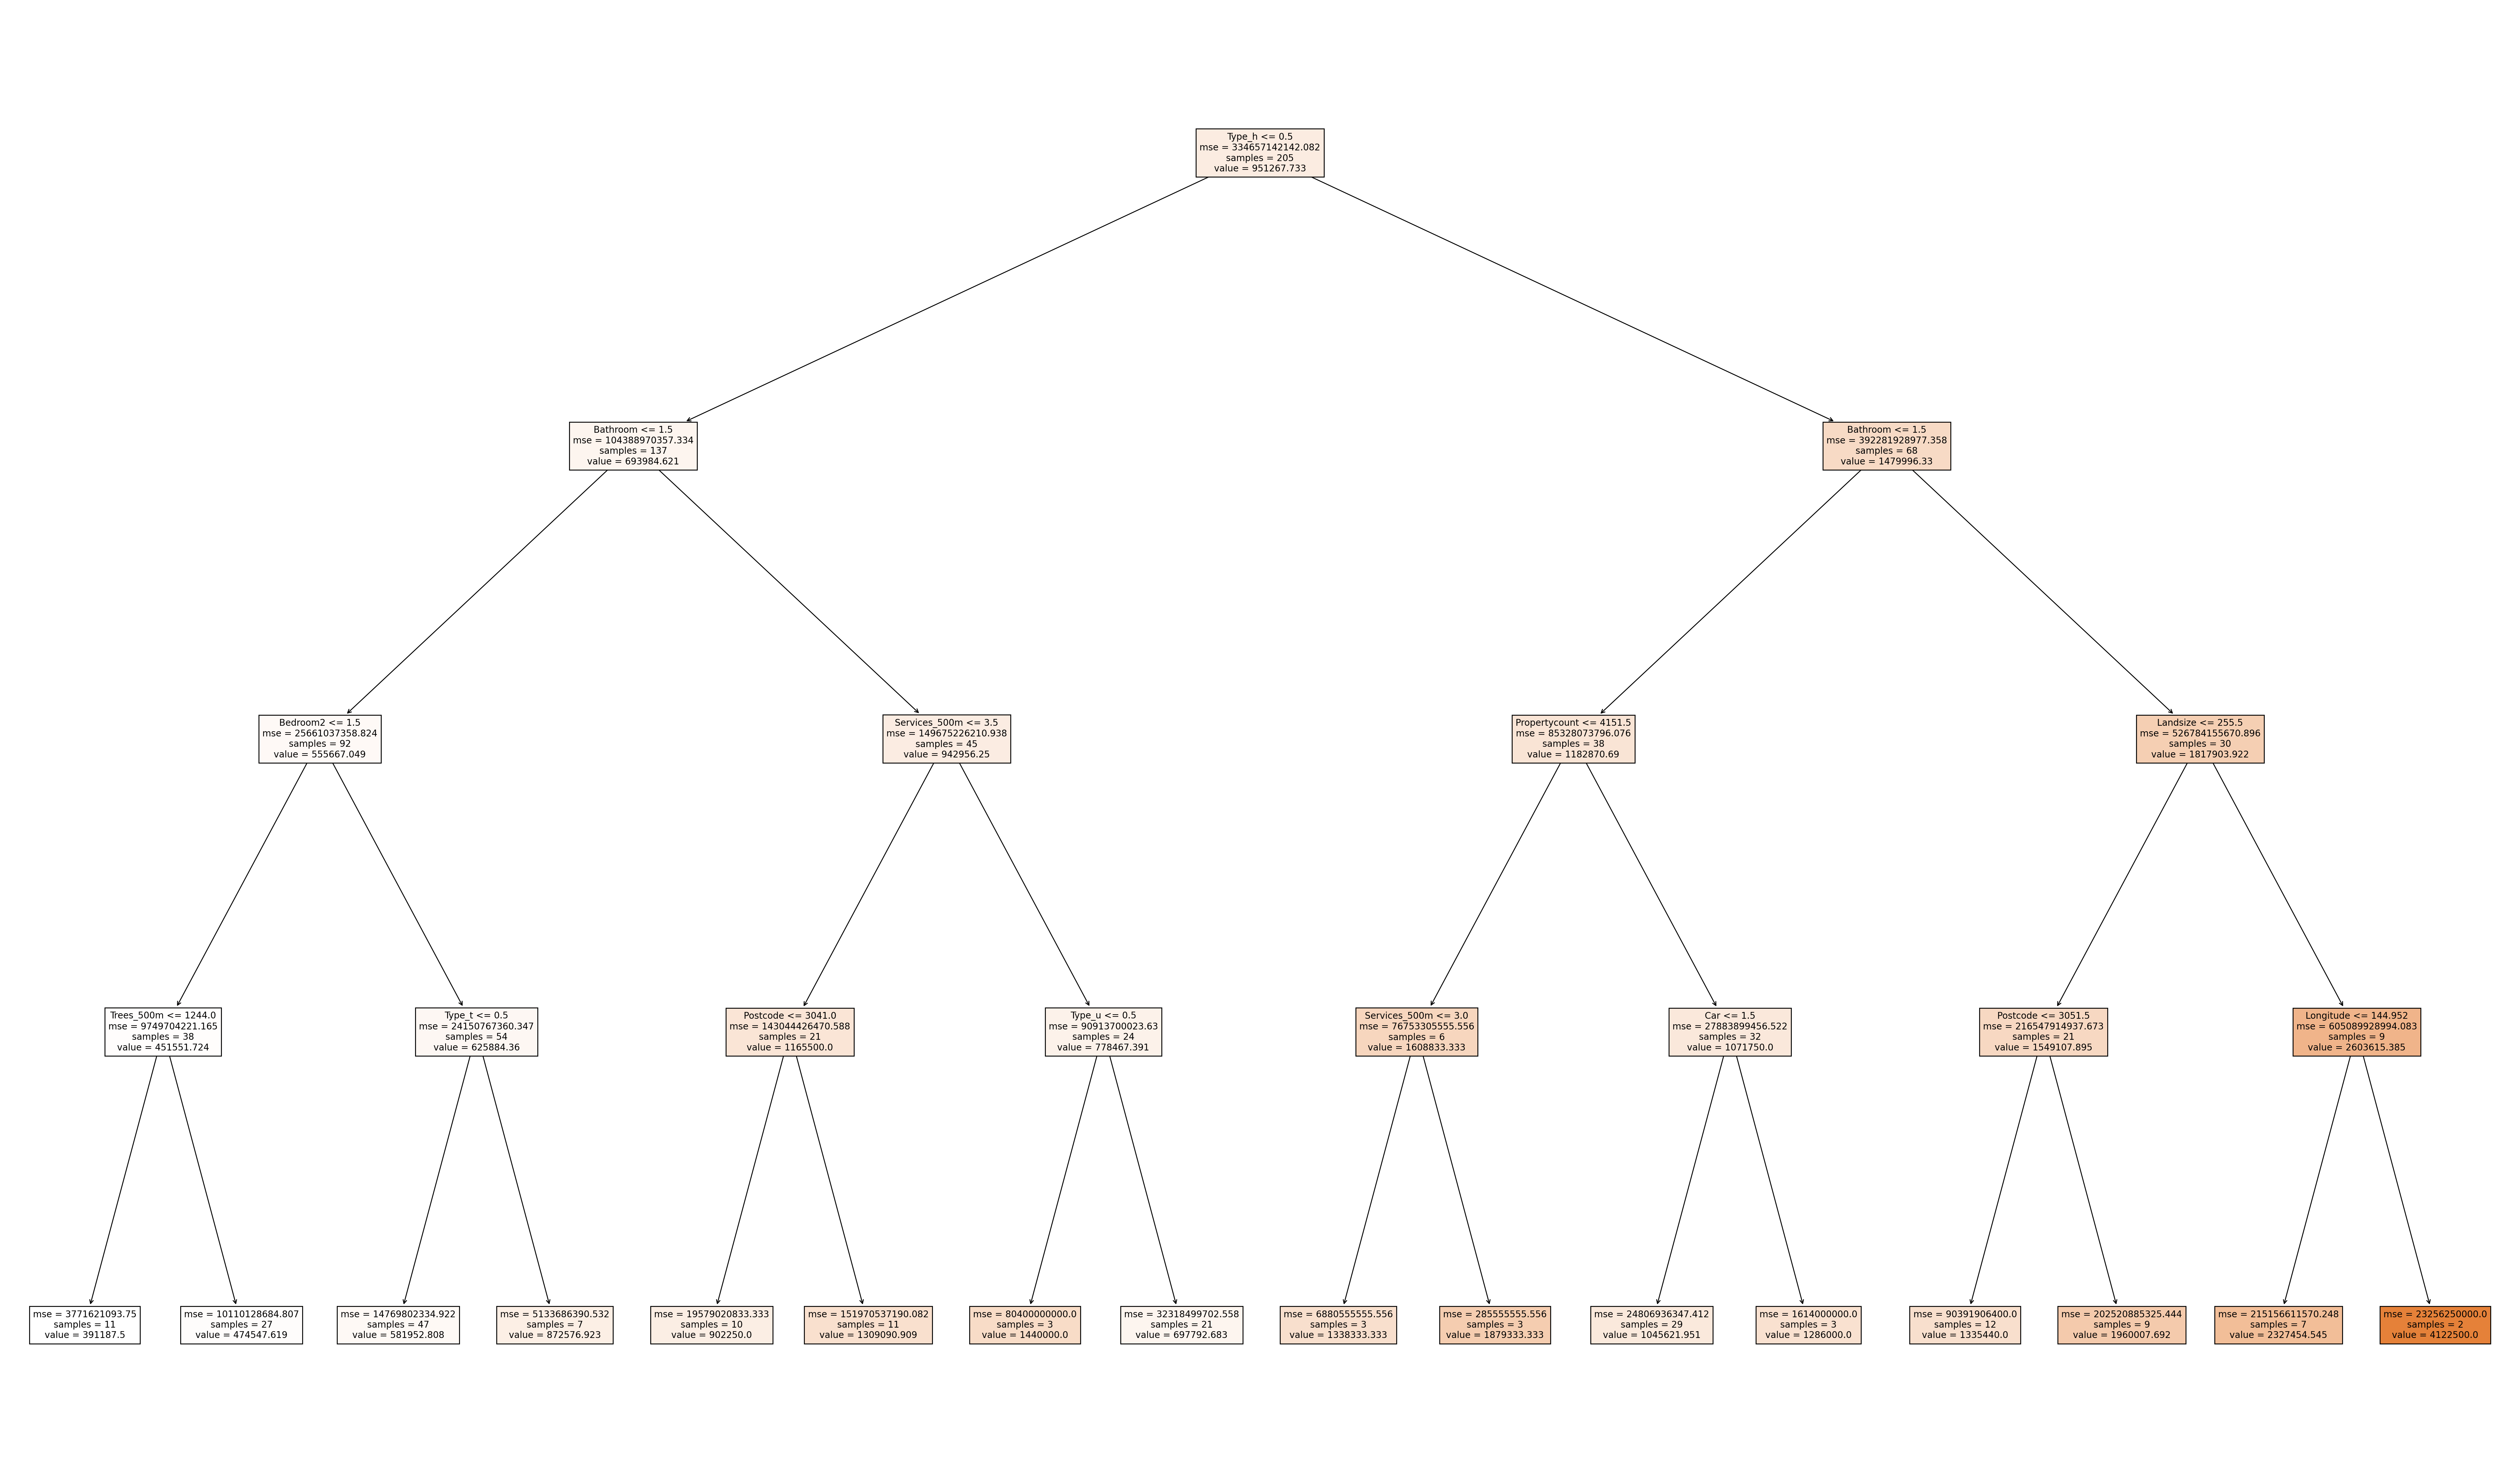

In [19]:
feature_list = list(X_train.columns)

fig, ax = plt.subplots(figsize=(50, 30), dpi=200)
rf_tree = model.estimators_[5]
#tree.plot_tree(model, fontsize=10, feature_names = feature_list, filled=True)
tree.plot_tree(rf_tree, fontsize=10, feature_names = feature_list, filled=True)
plt.show()

The regression tree above shows how our model is making its decisions to predict house price. The darker the leaf node, the more expensive the house prediction. While we showed its inaccuracies, our model does present trends, especially at the extremes. For very low number of nearby trees, price is almost always lower. Houses in less dense neighborhoods are cheaper, but only if they also have less access to services/landmarks. The model also clearly shows the effect of neighborhood on price.

Overall, we were a little dissappointed to see our hypotheses not confirmed as strongly as we had hoped. Rich people do not have a monopoly on access to all of Melbourne's resources and green spaces. This is also a good thing! And our exploration was a good lesson in data science: if you always find exactly what you are looking for, you're not really doing anything interesting or new. We hope we took you on an interesting and/or entertaining journey through the data of the wonderful city of Melbourne, Australia. Thanks!